# 목차
1. library import
2. 데이터 전처리
    - 2.1 결측치&중복 데이터 확인
    - 2.2 EDA
    - 2.3 추가 데이터
    - 2.4 파생변수 생성
    - 2.5 상관 분석
    - 2.6 불필요 칼럼 제거
    - 2.7 수치형 처리
    - 2.8 범주형 처리
    - 2.9 데이터 분할
3. 모델링
4. 모델 예측 및 저장
5. SHAP

# 분석 환경: VScode Python

# 1.library import

In [1]:
# import
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor, Pool
import optuna

import platform
import shap

warnings.filterwarnings('ignore')

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 시스템에 따라 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 기본 한글 폰트
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스, Colab 등

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [ ]:
# 제공 데이터 import
call = pd.read_csv('\call119_train.csv', encoding = 'cp949', index_col = 0)
cat = pd.read_csv('\cat119_train.csv', encoding = 'cp949', index_col = 0)

# 2. 데이터 전처리

### 2-1 결측치&중복 데이터 확인

In [4]:
# 결측치 확인
call.isnull().sum()

call119_train.tm              0
call119_train.address_city    0
call119_train.address_gu      0
call119_train.sub_address     0
call119_train.stn             0
call119_train.ta_max          0
call119_train.ta_min          0
call119_train.ta_max_min      0
call119_train.hm_min          0
call119_train.hm_max          0
call119_train.ws_max          0
call119_train.ws_ins_max      0
call119_train.rn_day          0
call119_train.call_count      0
dtype: int64

In [5]:
cat.isnull().sum()

cat119_train.tm              0
cat119_train.address_city    0
cat119_train.address_gu      0
cat119_train.sub_address     0
cat119_train.cat             0
cat119_train.sub_cat         0
cat119_train.stn             0
cat119_train.call_count      0
dtype: int64

In [ ]:
# 데이터 정보 확인 
call.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42924 entries, 1 to 42924
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   call119_train.tm            42924 non-null  int64  
 1   call119_train.address_city  42924 non-null  object 
 2   call119_train.address_gu    42924 non-null  object 
 3   call119_train.sub_address   42924 non-null  object 
 4   call119_train.stn           42924 non-null  int64  
 5   call119_train.ta_max        42924 non-null  float64
 6   call119_train.ta_min        42924 non-null  float64
 7   call119_train.ta_max_min    42924 non-null  float64
 8   call119_train.hm_min        42924 non-null  float64
 9   call119_train.hm_max        42924 non-null  float64
 10  call119_train.ws_max        42924 non-null  float64
 11  call119_train.ws_ins_max    42924 non-null  float64
 12  call119_train.rn_day        42924 non-null  float64
 13  call119_train.call_count    42924 no

In [7]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61771 entries, 1 to 61771
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   cat119_train.tm            61771 non-null  int64 
 1   cat119_train.address_city  61771 non-null  object
 2   cat119_train.address_gu    61771 non-null  object
 3   cat119_train.sub_address   61771 non-null  object
 4   cat119_train.cat           61771 non-null  object
 5   cat119_train.sub_cat       61771 non-null  object
 6   cat119_train.stn           61771 non-null  int64 
 7   cat119_train.call_count    61771 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 4.2+ MB


In [8]:
# call + cat merge
call.columns = ['tm', 'address_city', 'address_gu', 'sub_address', 'stn', 'ta_max', 'ta_min',
                'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day', 'call_count']
cat.columns = ['tm', 'address_city', 'address_gu', 'sub_address', 'cat', 'sub_cat', 'stn', 'call_count']

df = call.merge(cat, on = ['tm', 'address_city', 'address_gu', 'sub_address'])
df = df.drop(['call_count_x', 'stn_y'], axis = 1)
df = df.rename(columns = {'stn_x' : 'stn', 'call_count_y':'call_count'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61771 entries, 0 to 61770
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tm            61771 non-null  int64  
 1   address_city  61771 non-null  object 
 2   address_gu    61771 non-null  object 
 3   sub_address   61771 non-null  object 
 4   stn           61771 non-null  int64  
 5   ta_max        61771 non-null  float64
 6   ta_min        61771 non-null  float64
 7   ta_max_min    61771 non-null  float64
 8   hm_min        61771 non-null  float64
 9   hm_max        61771 non-null  float64
 10  ws_max        61771 non-null  float64
 11  ws_ins_max    61771 non-null  float64
 12  rn_day        61771 non-null  float64
 13  cat           61771 non-null  object 
 14  sub_cat       61771 non-null  object 
 15  call_count    61771 non-null  int64  
dtypes: float64(8), int64(3), object(5)
memory usage: 7.5+ MB


In [9]:
# 결측치 처리 
df = df.replace(-99, np.nan)
df = df.fillna(method='ffill')
df.describe()

,tm,stn,ta_max,ta_min,ta_max_min,hm_min,hm_max,ws_max,ws_ins_max,rn_day,call_count
count,6.177100e+04,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000
mean,2.021578e+07,835.680934,26.487766,18.911379,7.576387,57.142968,90.242955,4.747051,8.552536,10.000421,1.331936
std,1.086659e+04,259.170544,4.038878,4.725433,2.959963,17.496857,9.025431,2.329673,3.863257,27.933406,1.288823
min,2.020050e+07,159.000000,12.300000,2.700000,0.000000,2.300000,39.500000,1.200000,2.400000,0.000000,1.000000
25%,2.021052e+07,923.000000,23.700000,15.800000,5.400000,45.100000,85.900000,3.300000,6.100000,0.000000,1.000000
50%,2.021102e+07,938.000000,26.700000,19.700000,7.500000,58.200000,92.800000,4.200000,7.700000,0.000000,1.000000
75%,2.022102e+07,941.000000,29.400000,22.500000,9.600000,69.100000,97.100000,5.400000,9.900000,2.500000,1.000000
max,2.023103e+07,950.000000,37.600000,29.000000,23.000000,99.500000,100.000000,30.700000,37.800000,259.200000,72.000000


In [10]:
# 중복 데이터 확인
before_train_size = df.shape[0]
df = df.drop_duplicates()
print(f'중복 데이터 제거 개수 : {before_train_size - df.shape[0]}')
df.reset_index(drop=True, inplace=True)

중복 데이터 제거 개수 : 0


In [11]:
df.head()

,tm,address_city,address_gu,sub_address,stn,ta_max,ta_min,ta_max_min,hm_min,hm_max,ws_max,ws_ins_max,rn_day,cat,sub_cat,call_count
0,20200501,부산광역시,강서구,대저2동,904,23.7,16.6,7.1,63.2,90.3,5.8,10.6,0.0,구급,교통사고,1
1,20200501,부산광역시,강서구,천성동,921,24.3,15.4,8.9,64.2,96.4,4.8,8.6,0.0,구조,교통사고,1
2,20200501,부산광역시,금정구,금사동,940,25.6,17.2,8.4,46.6,76.4,4.8,8.3,0.0,구급,부상,1
3,20200501,부산광역시,금정구,금성동,941,25.3,17.1,8.2,46.6,76.4,7.1,9.7,0.0,기타,업무운행,1
4,20200501,부산광역시,금정구,남산동,939,26.5,16.7,9.8,46.6,76.4,5.7,8.1,0.0,구급,부상,1


### 2-2. EDA

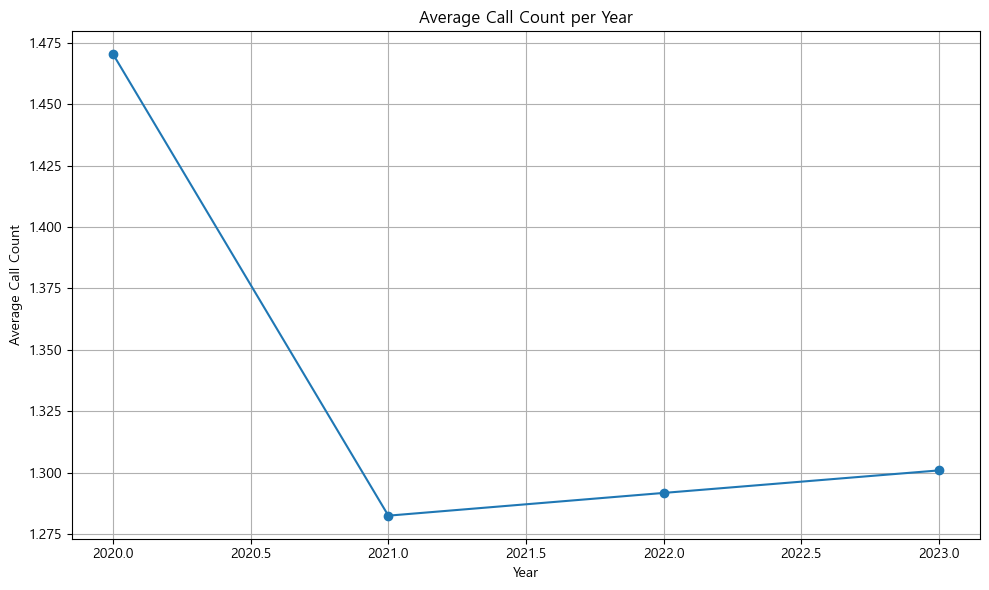

In [12]:
# 연도별 call count 평균
# 날짜 형식으로 변경
call['tm'] = pd.to_datetime(call['tm'].astype(str), format='%Y%m%d')
cat['tm'] = pd.to_datetime(cat['tm'].astype(str), format='%Y%m%d')

# 년, 월, 일 추출
call['year'] = call['tm'].dt.year
call['month'] = call['tm'].dt.month
call['day'] = call['tm'].dt.day

cat['year'] = cat['tm'].dt.year
cat['month'] = cat['tm'].dt.month
cat['day'] = cat['tm'].dt.day

# 연도별  call_count 평균
yearly_avg = cat.groupby('year')['call_count'].mean()

# 그래프 출력
plt.figure(figsize=(10, 6))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title('Average Call Count per Year')
plt.xlabel('Year')
plt.ylabel('Average Call Count')
plt.grid(True)
plt.tight_layout()
plt.show()

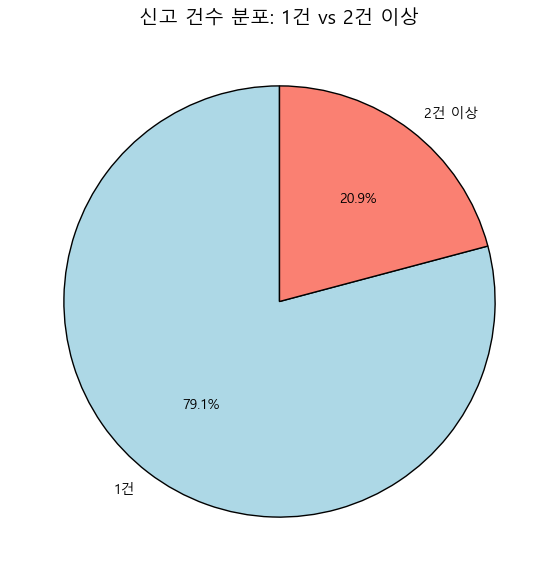

In [13]:
# 1건 / 2건 이상 분리
count_1 = (df['call_count'] == 1).sum()
count_2plus = (df['call_count'] > 1).sum()

# 데이터 구성
counts = [count_1, count_2plus]
labels = ['1건', '2건 이상']

# 원형 차트 그리기
plt.figure(figsize=(7, 7))
plt.pie(counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightblue', 'salmon'],
        wedgeprops={'edgecolor': 'k'})

plt.title('신고 건수 분포: 1건 vs 2건 이상', fontsize=14)
plt.show()

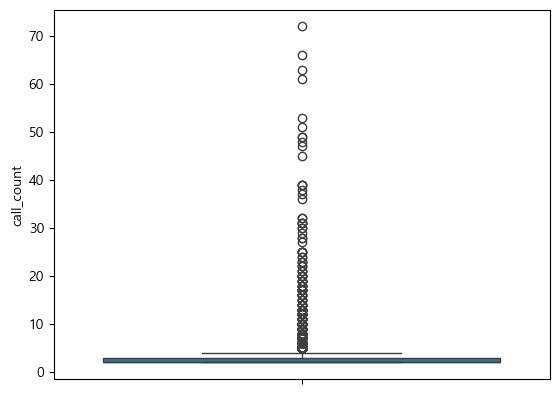

In [14]:
# call건수 >1 이상 boxplot
target = df.pop('call_count')
sns.boxplot(target[target > 1])
plt.show()

<Axes: title={'center': 'Top 20 신고 유형 비율'}, ylabel='cat_sub'>

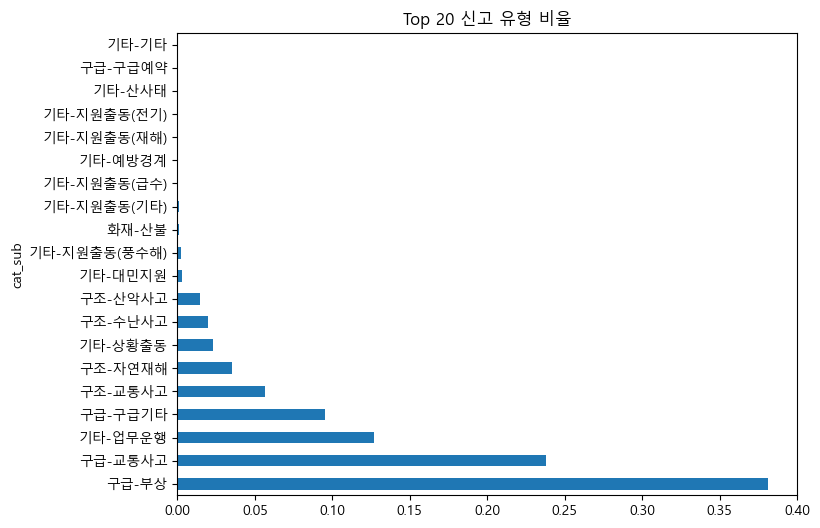

In [ ]:
# cat 건수 분포
# 시계열 코드 넣기
# 전체 카테고리 빈도 및 비율 확인
cat['cat_sub'] = cat['cat'] + '-' + cat['sub_cat']
cat_counts = cat['cat_sub'].value_counts(normalize=True)[:20]
cat_counts.plot(kind='barh', figsize=(8,6), title='Top 20 신고 유형 비율')

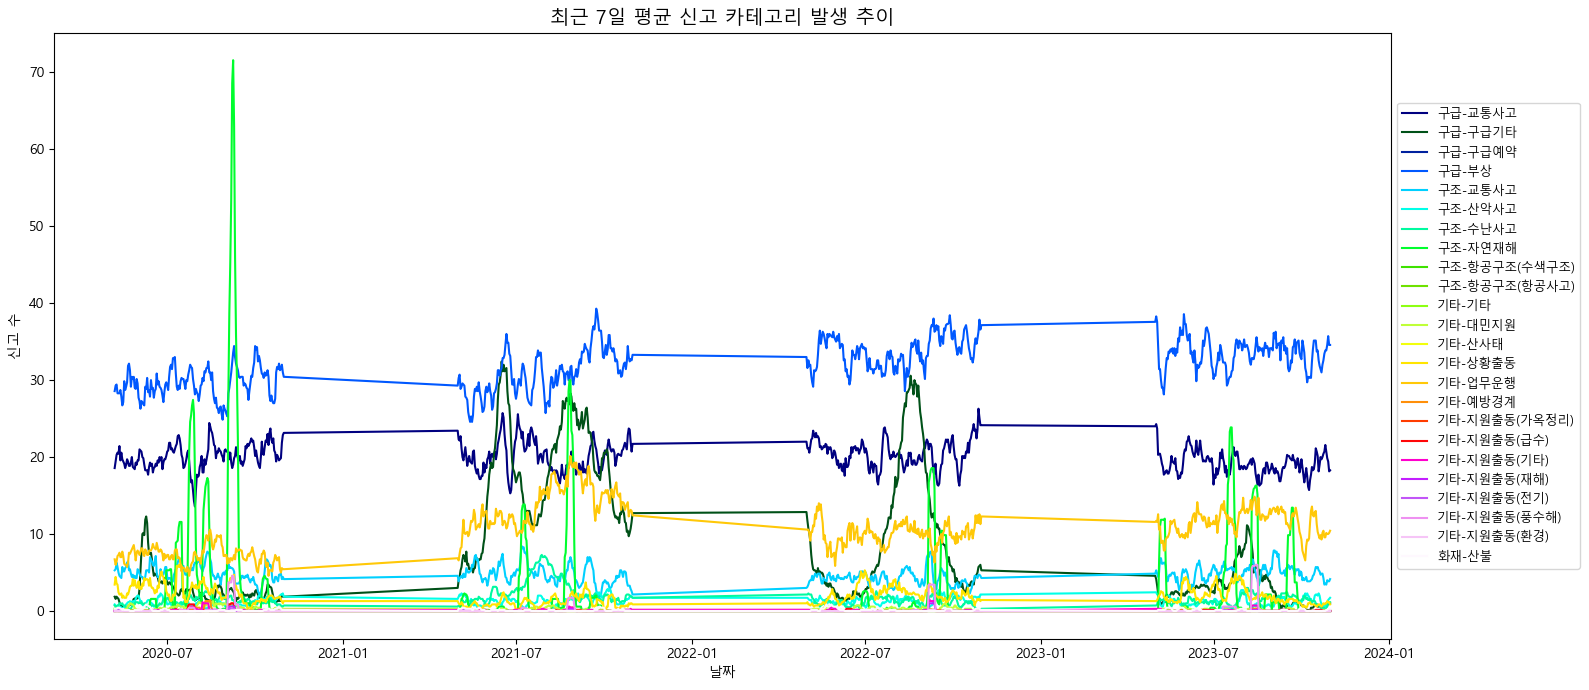

In [ ]:
# 시간 흐름에 따른 카테고리 변화 확인
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

cat_trend = (
    cat.groupby(['tm', 'cat_sub']).size().unstack(fill_value=0)
)

# 1. 7일 평균 rolling 계산
cat_trend_rolling = cat_trend.rolling(7).mean()

# 2. 컬럼 수에 맞는 색상 생성 (e.g., 20개면 20색)
num_cats = len(cat_trend_rolling.columns)
color_map = cm.get_cmap('gist_ncar', num_cats)  # 또는 'tab10', 'Set3' 등 다양한 colormap 가능

# 3. Plot
plt.figure(figsize=(16, 7))
for i, col in enumerate(cat_trend_rolling.columns):
    plt.plot(cat_trend_rolling.index, cat_trend_rolling[col], label=col, color=color_map(i))

plt.title('최근 7일 평균 신고 카테고리 발생 추이', fontsize=14)
plt.xlabel('날짜')
plt.ylabel('신고 수')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

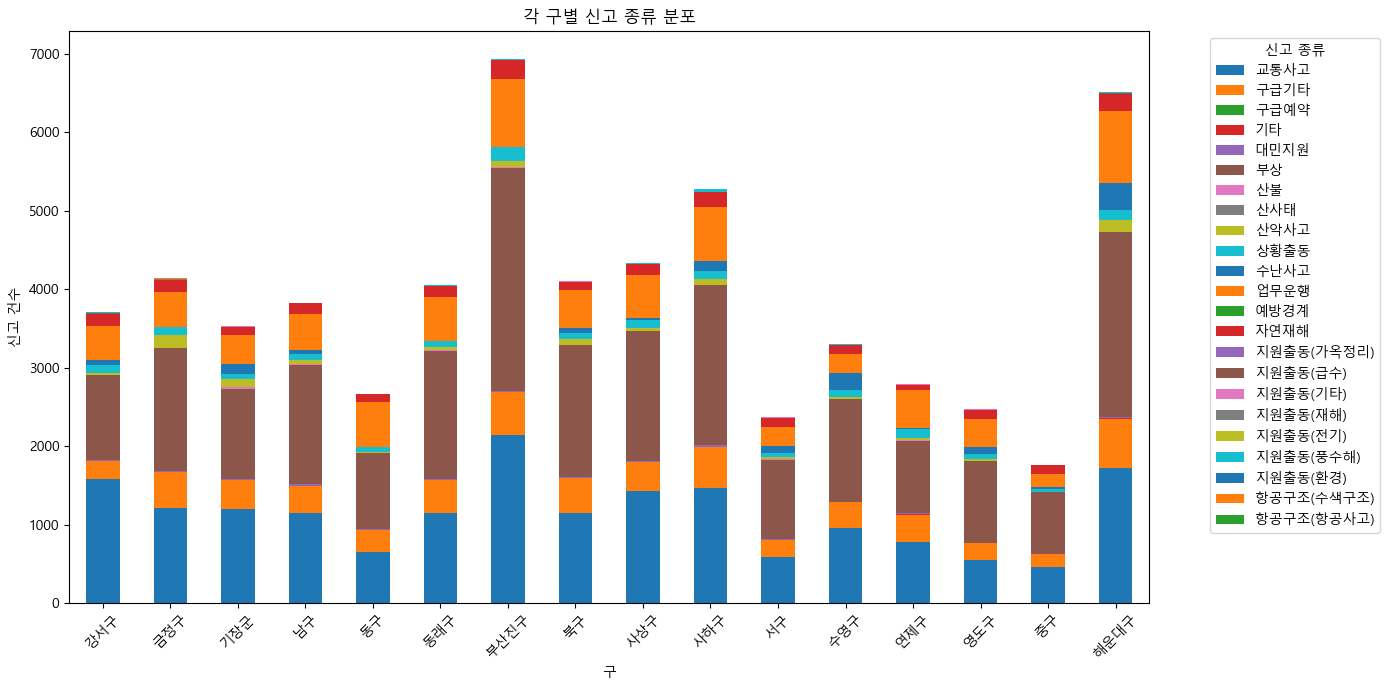

In [17]:
# 구별 카테고리별 신고 분포
# 구별(cat119_train.address_gu) x 신고종류(cat119_train.cat) 교차표 생성
cross_tab = pd.crosstab(cat['address_gu'], cat['sub_cat'])

# 그래프 크기 설정
plt.figure(figsize=(14, 7))

# 누적 막대그래프
cross_tab.plot(kind='bar', stacked=True, figsize=(14, 7))

plt.title('각 구별 신고 종류 분포')
plt.xlabel('구')
plt.ylabel('신고 건수')
plt.xticks(rotation=45)
plt.legend(title='신고 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

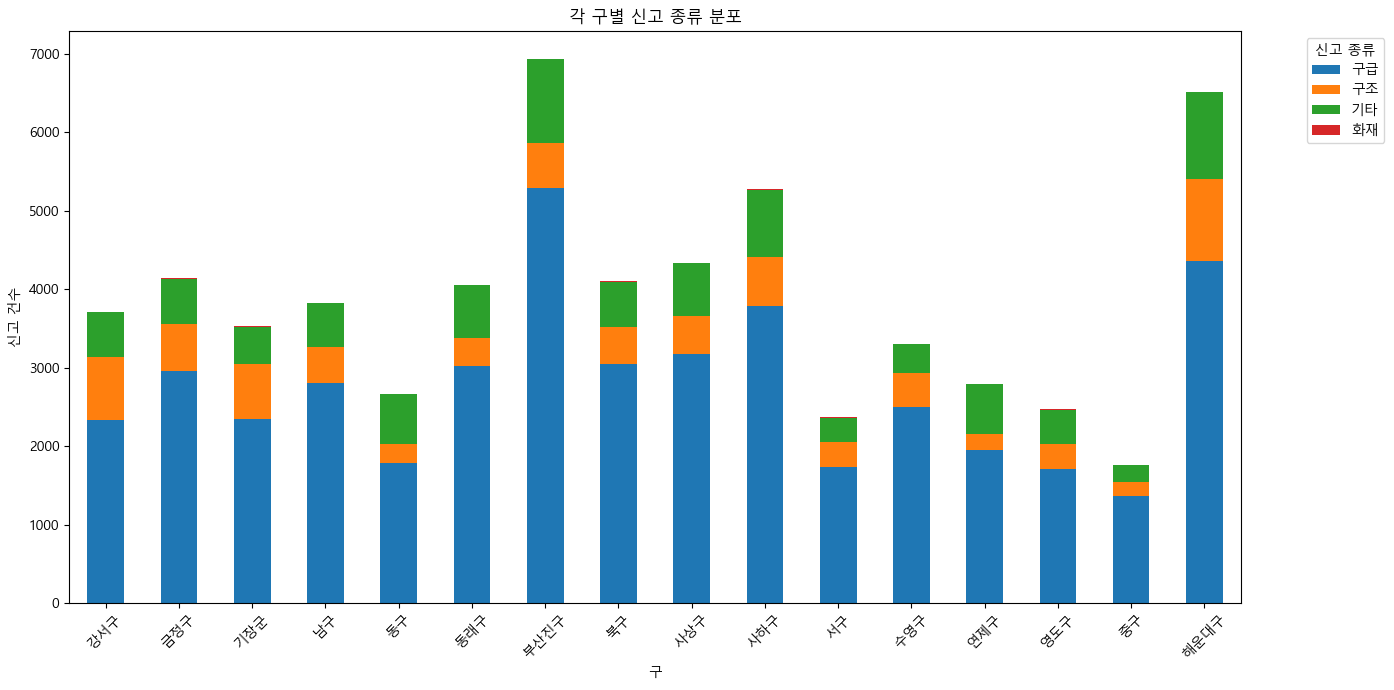

In [ ]:
# 구별(address_gu) x 신고종류(cat) 교차표 생성
cross_tab = pd.crosstab(cat['address_gu'], cat['cat'])

# 그래프 크기 설정
plt.figure(figsize=(14, 7))

# 누적 막대그래프
cross_tab.plot(kind='bar', stacked=True, figsize=(14, 7))

plt.title('각 구별 신고 종류 분포')
plt.xlabel('구')
plt.ylabel('신고 건수')
plt.xticks(rotation=45)
plt.legend(title='신고 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 2-3 추가 데이터

In [ ]:
# population merge
popu = pd.read_excel('\일별 행정동 연령 생활인구 월별 일평균.xlsx')

In [ ]:
# 1. 인구 데이터 행정동명 구분 % 기준 년월 구분
# address_gu/sub_address
# '행정도명'을 띄어쓰기를 기준으로 나눔
data = df
popu_data = popu

popu_data[['address_gu', 'sub_address']] = popu['행정동명'].str.split(' ', n=1, expand=True)
popu_data[['year', 'month']] = popu['기준년월'].str.split('-', n=1, expand=True)

# 2. 데이터 구분을 위해, 필요없는 열 삭제 
del popu_data['행정동코드']
del popu_data['행정동명']
del popu_data['기준년월']

# 3. 수치형 변환 
cols_to_convert = ['평균주거인구수', '평균직장인구수', '평균방문인구수']
for col in cols_to_convert:
    popu_data[col] = popu_data[col].str.replace(',', '').astype(int)
popu_data['year'] = popu_data['year'].astype(int)
popu_data['month'] = popu_data['month'].astype(int)

# 4. 그룹화 및 합계 집계
grouped = popu_data.groupby(['address_gu', 'sub_address', 'year', 'month'])[['평균주거인구수', '평균직장인구수', '평균방문인구수']].sum().reset_index()

# 5. 고유 값 집합 만들기
set1 = set(grouped['sub_address'].unique()) # 인구 데이터
set2 = set(data['sub_address'].unique())    # 오리지널 데이터 
intersection = set1 & set2          # 교집합
# 위에 교집합에 해당하지 않은 sub_address만 남김. 
filtered = data[~data['sub_address'].isin(intersection)]
sorted(filtered['sub_address'].unique())

# 자동 매칭이 되지 않은 지역, 수동 매핑 코드 

# manual_mapping 
manual_mapping = {'가야동': '가야1동'} # <-예시 자료: 지역에 관한 정보로 생략

# 6.수동 매핑 적용 함수
def map_sub_address(row):
    if row['sub_address'] in intersection:
        return row['sub_address']
    else:
        return manual_mapping.get(row['sub_address'], row['sub_address'])  # 없으면 원래 값 유지

data['mapped_sub_address'] = data.apply(map_sub_address, axis=1)

data['tm'] = pd.to_datetime(data['tm'], format = '%Y%m%d')

def preprocess_weather_data(df):
    import pandas as pd
    
    # 날짜 파생 변수
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['day'] = df['tm'].dt.day
    df['weekday'] = df['tm'].dt.dayofweek
    return df

data = preprocess_weather_data(data)

# grouped에서 매핑을 위해 컬럼명 정리
grouped_renamed = grouped.rename(columns={'sub_address': 'mapped_sub_address'})

# 기준 컬럼: sub_address, year, month
merge_keys = ['mapped_sub_address', 'year', 'month']

# 7. data에 인구 정보 병합 (left join)
data_merged = data.merge(
    grouped_renamed[merge_keys + ['평균주거인구수', '평균직장인구수', '평균방문인구수']],
    on=merge_keys,
    how='left'
)

In [ ]:
# 최종 정리 데이터 
train= pd.read_csv('\train_pop_data.csv',encoding='cp949')
test = pd.read_csv('\test_pop_data.csv',encoding='cp949')
sub = pd.read_csv('\test_call119.csv', encoding = 'cp949')

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61771 entries, 0 to 61770
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tm              61771 non-null  object 
 1   address_city    61771 non-null  object 
 2   address_gu      61771 non-null  object 
 3   sub_address     61771 non-null  object 
 4   stn             61771 non-null  int64  
 5   ta_max          61771 non-null  float64
 6   ta_min          61771 non-null  float64
 7   ta_max_min      61771 non-null  float64
 8   hm_min          61771 non-null  float64
 9   hm_max          61771 non-null  float64
 10  ws_max          61771 non-null  float64
 11  ws_ins_max      61771 non-null  float64
 12  rn_day          61771 non-null  float64
 13  cat             61771 non-null  object 
 14  sub_cat         61771 non-null  object 
 15  call_count      61771 non-null  int64  
 16  population      61771 non-null  int64  
 17  old_population  61771 non-null 

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739 entries, 0 to 12738
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tm              12739 non-null  object 
 1   address_city    12739 non-null  object 
 2   address_gu      12739 non-null  object 
 3   sub_address     12739 non-null  object 
 4   stn             12739 non-null  int64  
 5   ta_max          12739 non-null  float64
 6   ta_min          12739 non-null  float64
 7   ta_max_min      12739 non-null  float64
 8   hm_min          12739 non-null  float64
 9   hm_max          12739 non-null  float64
 10  ws_max          12739 non-null  float64
 11  ws_ins_max      12739 non-null  float64
 12  rn_day          12739 non-null  float64
 13  cat             12739 non-null  object 
 14  sub_cat         12739 non-null  object 
 15  population      12739 non-null  int64  
 16  old_population  12739 non-null  int64  
 17  평균주거인구수         12739 non-null 

### 2-4 파생변수 생성

In [60]:
# target 변수 분리
target = train.pop('call_count')

In [61]:
# tm 전처리 
train['tm'] = pd.to_datetime(train['tm'])
test['tm'] = pd.to_datetime(test['tm'])

In [62]:
# 년, 월, 일, 주말 추출
train['year'] = train['tm'].dt.year
train['month'] = train['tm'].dt.month
train['day'] = train['tm'].dt.day
train['weekday'] = train['tm'].dt.dayofweek

test['year'] = test['tm'].dt.year
test['month'] = test['tm'].dt.month
test['day'] = test['tm'].dt.day
test['weekday'] = test['tm'].dt.dayofweek

In [63]:
# stn 문자열 변경 
train['stn'] = train['stn'].astype(str)
test['stn'] = test['stn'].astype(str)

In [64]:
# 풍속 평균
train['wind_mean'] = (train['ws_ins_max'] + train['ws_max']) / 2
test['wind_mean'] = (test['ws_ins_max'] + test['ws_max']) / 2

# 습도 범위
train['hm_range'] = train['hm_max'] - train['hm_min']
test['hm_range'] = test['hm_max'] - test['hm_min']

# 이동평균 (기온, 습도)
train['ta_max_3d_ma'] = train.groupby('address_gu')['ta_max'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
train['hm_max_3d_ma'] = train.groupby('address_gu')['hm_max'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
test['ta_max_3d_ma'] = test.groupby('address_gu')['ta_max'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
test['hm_max_3d_ma'] = test.groupby('address_gu')['hm_max'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# 강수량 구간화
train['rn_day'] = train['rn_day'].apply(lambda x: 0 if x < 0 else x)
bins = [-0.1, 0, 10, 30, 70, train['rn_day'].max()]
labels = ['없음', '약한 비', '보통 비', '강한 비', '매우 강한 비']
train['rn_day_bin'] = pd.cut(train['rn_day'], bins=bins, labels=labels)

test['rn_day'] = test['rn_day'].apply(lambda x: 0 if x < 0 else x)
bins = [-0.1, 0, 10, 30, 70, test['rn_day'].max()]
labels = ['없음', '약한 비', '보통 비', '강한 비', '매우 강한 비']
test['rn_day_bin'] = pd.cut(test['rn_day'], bins=bins, labels=labels)


In [65]:
# 자연재해 여부
train['disaster_day'] = train['sub_cat'].isin(['자연재해','지원출동(풍수해']).astype(int)
test['disaster_day'] = test['sub_cat'].isin(['자연재해','지원출동(풍수해']).astype(int)

In [ ]:
# 코로나 영향권 여부
train['is_covid_year'] = (train['year'] == 2020).astype(int)
test['is_covid_year'] = (test['year'] == 2020).astype(int)

In [67]:
# 지역 그룹 분류 기준 정의
coastal = ['해운대구', '수영구', '영도구', '중구', '동구', '서구', '남구']
urban = ['부산진구', '동래구', '연제구']
mountain = ['금정구', '기장군']
mountain = ['금정구', '기장군']
lowland = ['강서구', '북구', '사상구', '사하구']

# 각 지역 그룹에 해당하는지 여부를 이진 변수로 직접 생성
for df in [train, test]:
    df['region_coastal'] = df['address_gu'].isin(coastal).astype(int)
    df['region_urban'] = df['address_gu'].isin(urban).astype(int)
    df['region_mountain'] = df['address_gu'].isin(mountain).astype(int)
    df['region_lowland'] = df['address_gu'].isin(lowland).astype(int)

### 2-5 상관분석

In [69]:
train.columns = ['tm', 'address_city', 'address_gu', 'sub_address', 'stn', 'ta_max',
       'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max',
       'rn_day', 'cat', 'sub_cat', 'population', 'old_population', 'mean_live_pop',
       'mean_work_pop', 'mean_visit_pop', 'year', 'month', 'day', 'weekday', 'wind_mean',
       'hm_range', 'ta_max_3d_ma', 'hm_max_3d_ma', 'rn_day_bin',
       'disaster_day', 'is_covid_year', 'region_coastal', 'region_urban',
       'region_mountain', 'region_lowland']

In [74]:
test.columns = ['tm', 'address_city', 'address_gu', 'sub_address', 'stn', 'ta_max',
       'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max',
       'rn_day', 'cat', 'sub_cat', 'population', 'old_population', 'mean_live_pop',
       'mean_work_pop', 'mean_visit_pop', 'year', 'month', 'day', 'weekday', 'wind_mean',
       'hm_range', 'ta_max_3d_ma', 'hm_max_3d_ma', 'rn_day_bin',
       'disaster_day', 'is_covid_year', 'region_coastal', 'region_urban',
       'region_mountain', 'region_lowland']

In [75]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns

# 수치형 변수만 필터링
train_numeric = train[numeric_cols]
cols_to_drop = ['region_coastal', 'region_urban', 'region_mountain', 'region_lowland']

train_numeric = train_numeric.drop(columns=cols_to_drop)
train_corr = train_numeric.corr()

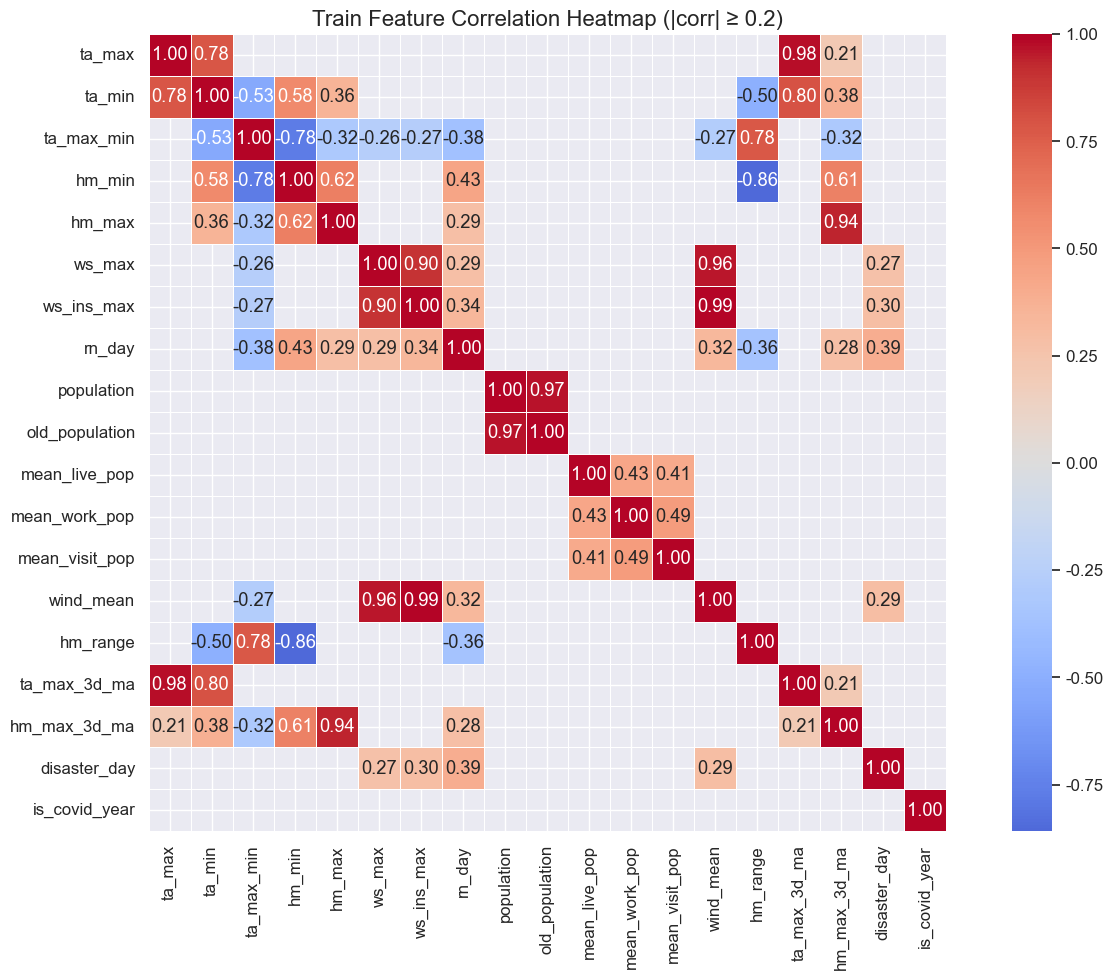

In [76]:
# 상관계수 행렬 계산 
# 절댓값 0.2 미만인 값은 NaN으로 설정
filtered_corr = train_corr.mask(train_corr.abs() < 0.2)

plt.figure(figsize=(14, 10))
sns.set(font_scale=1.1)

sns.heatmap(
    filtered_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar=True
)

plt.title("Train Feature Correlation Heatmap (|corr| ≥ 0.2)", fontsize=16)
plt.tight_layout()
plt.show()

- 높은 상관 관계가 나타나는 'ws_ins_max','ta_max_3d_ma','hm_max_3d_ma' 제거


### 2-6 불필요 칼럼 제거

In [ ]:
# 삭제할 열 목록
cols_to_drop = [
    'cat', 'sub_cat',                                # 데이터 누설 방지 
    'ws_ins_max','ta_max_3d_ma','hm_max_3d_ma',      # 높은 상관계수에 의해 삭제
    'address_city','rn_day_bin'                      # 변수 중요도 낮음.
    ]

# drop으로 처리
train = train.drop(columns=cols_to_drop, errors='ignore')
test = test.drop(columns=cols_to_drop, errors='ignore')

In [38]:
train.columns

Index(['tm', 'address_gu', 'sub_address', 'stn', 'ta_max', 'ta_min',
       'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'rn_day', 'population',
       'old_population', 'mean_live_pop', 'mean_work_pop', 'mean_visit_pop',
       'year', 'month', 'day', 'weekday', 'wind_mean', 'hm_range',
       'disaster_day', 'is_covid_year', 'region_coastal', 'region_urban',
       'region_mountain', 'region_lowland'],
      dtype='object')

### 2-7 수치형 처리

In [78]:
from sklearn.preprocessing import MinMaxScaler

num_cols = train.select_dtypes(include = ['int', 'float']).columns
date_cols = ['year', 'month', 'day', 'weekday']
cols = [x for x in num_cols if x not in date_cols]

scaler = MinMaxScaler()
train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])

### 2-8 범주형 처리

In [79]:
# 범주형 처리
cat_cols = ['address_gu', 'sub_address', 'stn']
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

### 2-9 데이터 분할

In [80]:
X = train.drop(columns = ['tm'])

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, target, test_size = 0.2, random_state = 0)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((49416, 27), (12355, 27), (49416,), (12355,))

# 3. 모델링

- hyper parameter
- ✅ Best Parameters:

{'iterations': 1172, 'depth': 6, 'learning_rate': 0.0038166161833928687, 'l2_leaf_reg': 6.178500608595952, 'bagging_temperature': 0.4169323820127707, 'random_strength': 2.6137903340558464, 'border_count': 211}

In [47]:
best_params = {
    "loss_function": "Poisson",
    "iterations": 1172,
    "depth": 6,
    "learning_rate": 0.0038166161833928687,
    "l2_leaf_reg": 6.178500608595952,
    "bagging_temperature": 0.4169323820127707,
    "random_strength": 2.6137903340558464,
    "border_count": 211,
    "cat_features": cat_cols,
    "random_state": 0,
    "verbose": 100
}

In [ ]:
# optuna

def objective(trial):
    # 튜닝할 하이퍼파라미터 범위 정의
    params = {
        "loss_function": "Poisson",
        "random_state": 0,
        "verbose": 0,
        "iterations": trial.suggest_int("iterations", 300, 1500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
    }

    # CatBoostRegressor 훈련
    model = CatBoostRegressor(**params, cat_features=cat_cols)
    model.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)  
    return rmse

# Optuna Study 정의 및 실행
study = optuna.create_study(direction="minimize", study_name="CatBoost_Tuning")
study.optimize(objective, n_trials=50, timeout=600)  

# 최적 파라미터 출력
print("✅ Best Trial:")
print(study.best_trial)

print("✅ Best Parameters:")
print(study.best_params)

In [49]:
# model fit
cat_model = CatBoostRegressor(**best_params)
cat_model.fit(X_train, y_train)

0:	learn: 0.9992474	total: 57.4ms	remaining: 1m 7s
100:	learn: 0.9417885	total: 5.52s	remaining: 58.5s
200:	learn: 0.9087567	total: 11s	remaining: 53.2s
300:	learn: 0.8897065	total: 16.7s	remaining: 48.2s
400:	learn: 0.8786329	total: 22.4s	remaining: 43s
500:	learn: 0.8711150	total: 28.2s	remaining: 37.8s
600:	learn: 0.8659324	total: 34.1s	remaining: 32.4s
700:	learn: 0.8623014	total: 40s	remaining: 26.9s
800:	learn: 0.8596692	total: 46.3s	remaining: 21.4s
900:	learn: 0.8577101	total: 52.4s	remaining: 15.8s
1000:	learn: 0.8562361	total: 58.7s	remaining: 10s
1100:	learn: 0.8550050	total: 1m 4s	remaining: 4.18s
1171:	learn: 0.8542783	total: 1m 9s	remaining: 0us


In [50]:
# Valid 검증 
y_pred = cat_model.predict(X_val)

from sklearn.metrics import mean_absolute_error, r2_score

print("📊 MAE:", mean_absolute_error(y_val, y_pred))
print("📊 RMSE:", root_mean_squared_error(y_val, y_pred))
print("📊 R2:", r2_score(y_val, y_pred))

📊 MAE: 0.4379130944948917
📊 RMSE: 0.979870968639383
📊 R2: 0.4523045591438587


# 4. 모델 예측 및 저장

In [51]:
# 저장
X_test = test.drop(columns = ['tm'])
pred = cat_model.predict(X_test)
pred = np.round(pred).astype(int)

test['call_count'] = pred

In [52]:
test_group = test.groupby(
    ['tm', 'address_gu', 'sub_address'],
    observed=True  # 또는 observed=False
)['call_count'].sum().reset_index()

test_group = test_group.rename(columns={
    'tm': 'TM'
})

In [ ]:

sub = pd.read_csv('\test_call119.csv', encoding = 'cp949')
sub['TM'] = pd.to_datetime(sub['TM'], format='%Y%m%d')

In [55]:
submit = pd.merge(
    sub,
    test_group,
    how='left',
    on=['TM', 'address_gu', 'sub_address']
)
sub['call_count'] = submit['call_count_y']

In [ ]:
sub.to_csv('\250237.csv', index = False, encoding = 'cp949')

# 5. SHAP

In [56]:
# Tree 기반 모델: TreeExplainer 사용
explainer = shap.TreeExplainer(cat_model) 

# SHAP 값 계산 (X_train은 학습 데이터의 feature set)
shap_values = explainer.shap_values(X_train)

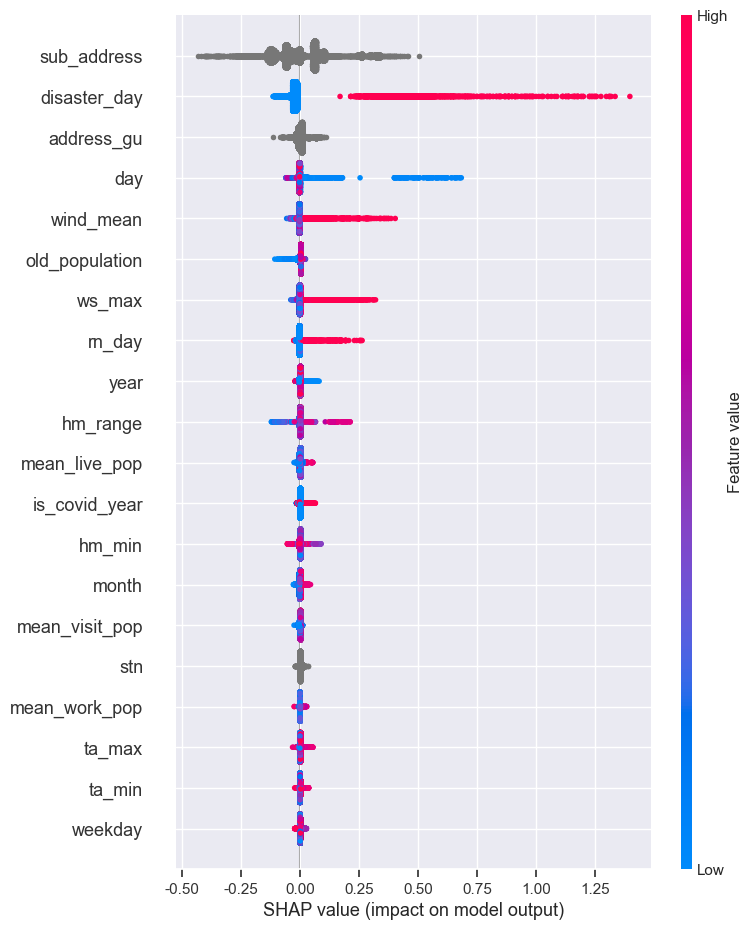

In [57]:
# 요약 플롯 (전체 feature 영향도)
shap.summary_plot(shap_values, X_train)